# Standard Spatial-Step Method

This method is used in most practical GVF solvers.
- This method solves sequentially for y1, y2, y3, ... starting at the control section (upstream or downstream end) with known water depth y0.
- Step size ($\Delta x$) must be small enough so that changes in water depth aren’t very large. Otherwise estimates of the friction slope and the velocity head are inaccurate
>1. For subcritical flows, calculations start downstream.
>2. For supercritical flows, calculations start upstream.

:::{note}
Our textbook calls this class of computations **Depth Computed from Distance**, I choose to call it Fixed Space Step, Variable Depth as below
:::

## Fixed Spatial Step, Variable Depth

The fixed-depth change, variable-space result above is a useful tool, but not terribly practical because we mostly perform engineering hydraulics calculations to estimate values (depth, pressure, force) at prescribed locations in space, so we need another approach to the problem where we can prescribe the spatial locations, and solve for the depths.

First the gradually varied flow equation is rearranged for relating the change in specific energy between two section to the spatial difference and the slope differences as

$$ \Delta h_s = \Delta (h + \frac{V^2}{2g}) = \Delta x (S_o - S_f) $$

The computation of $h_{i+1},V_{i+1}$ from $h_i,V_i$ is performed by iteration.
An initial value for $h_{i+1}$ that is known to be too large is used in the above Equation  along with the known value of $h_i$ to compute a trial value $h_{s(i+1)}$.

Then the trial value is used in the right hand side of the Equation 

$$ h_s = (h + \frac{V^2}{2g}) $$


The two trial values are compared and the next value of $h_{i+1}$ is computed by sucessively decreasing until the two values computed by the difference equation and the definition of specific energy coincide.  The example below uses a method from Hamming to make the comparisons and adjust the guesses until they are sufficiently close enough.

### Example 3 (Non-Prismatic Channel), Fixed Spatial Steps)
A plan view of a rectangular channel of variable width as shown below

![](NonPrismaticExample.png)


The channel conveys $Q=100~m^3/sec$, with a bottom slope of $0.001$ and average Manning's $n$ value of $0.033$.  
A backwater curve is caused by a weir at the downstream end (to the right in the figure) by a 7 meter tall weir.
Flow depth over the weir is at critical depth $h_c = 2.17$ meters.  Normal flow in the upstream portion for 10-meter channel width is $h_n = 5.6$ meters.  Using the fixed space step method determine and plot a profile view of the water surface and channel bottom.

The method employed is attributed to Hamming (cite and link to readings) that implements a Newton's-like method to match the left and right side of the difference equation.  

Here is our algorithm, first we set up some problem constants:

In [8]:
# Hamming's Method for Backwater Curve
imax = 31             #number of computational stations
dx = -1000.0            #spacing between stations
manningsN = 0.033     #mannings n value
slopeChan = 0.001     #channel slope
normalD  = 5.6       #upstream station normal depth
controlD = 9.17       #downstream station control depth
discharge = 100.0       #steady discharge

Next we define the plan view geometry, in this example we explicitly enter the values, but we could just as well read the geometry from a file to generalize the script.

In [9]:
topwidth = [10,10,10,11,12,13,14,13,12,11,10,9,8,7,8,9,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
topwidth = [float(i) for i in topwidth] # use of range() to set indices

With topwidth defined, we can compute values of velocity at the control section (downstream pool in the example). The conrtol section has position 0 in the various lists within our script. Observe the two ways we can populate the vectors with constants, use whichever you fancy!

In [10]:
velo = [0] * imax # allocate a velocity vector, put zeroes everywhere
velo[0] = discharge/topwidth[0]/controlD #set velocity at control section
depth = [normalD for i in range(0,imax)] # allocate a depth vector, put zeroes everywhere
spDepth = [0 for i in range(0,imax)] # allocate a sp. depth vector, put zeroes everywhere
spDepthT = [0 for i in range(0,imax)] # allocate a sp. depth vector, put zeroes everywhere

Now set control section depth, and specific energy

In [11]:
depth[0] = controlD # set control section depth
spDepth[0] = ((velo[0]**2)/(2.0*9.81)) + depth[0]

Now we implement the algorithm, starting from section 1 (just upstream of the control section) we use the difference equation and Hamming's method to find a value of depth that satisfies the difference equation.  Here are three loops, an outer one that processes each section and two inner loops that perform the balancing act - notice how the script breaks from a loop, when the conditions are satisfied.

In [12]:
## begin for loop 0 
for i in range(1,imax):
    depth[i] = 10
    difn = 1.0
    dh = 1.0
### begin do while loop 1
    while (dh > 0.0001):
        dif = difn
        ntest = 0
        depth[i] = depth[i]-dh
#### begin do while loop 2
        while (dh > 0):
            velo[i] =discharge/topwidth[i]/depth[i]
            avgDepth = 0.5*(depth[i-1]+depth[i])
            avgTopW = 0.5*(topwidth[i-1]+topwidth[i])
            avgV = discharge/avgTopW/avgDepth
            hydR = avgDepth*avgTopW/(avgTopW+2.0*avgDepth)
            sFric = (avgV**2)*(manningsN**2)/(hydR**(1.33))
            spDepth[i] = spDepth[i-1]+(slopeChan-sFric)*dx
            spDepthT[i] = depth[i]+(velo[i]**2/(2.0*9.81))
            difn = spDepthT[i]-spDepth[i]
# update
            if(ntest > 0):
                dh = dh/10.0
                break #break from do while loop 2
            if(dif*difn > 0):
                break #break from do while loop 2
            depth[i] = depth[i] + dh
            ntest = 1
#### end do while loop 2
### end do while loop 1
## end for loop 0

Now we prepare the output for plotting

In [13]:
distance = [0]*imax
bottom = [0]*imax
watersurface = [0]*imax
for i in range(1,imax):
    distance[i] = distance[i-1]+dx 
    bottom[i] = -distance[i]*slopeChan
    watersurface[i] = depth[i]+bottom[i]
watersurface[0] = depth[0]+bottom[0] # don't forget the control section!

Here we just reuse the plotting methods from prior lessons, but substitute in the correct vector names

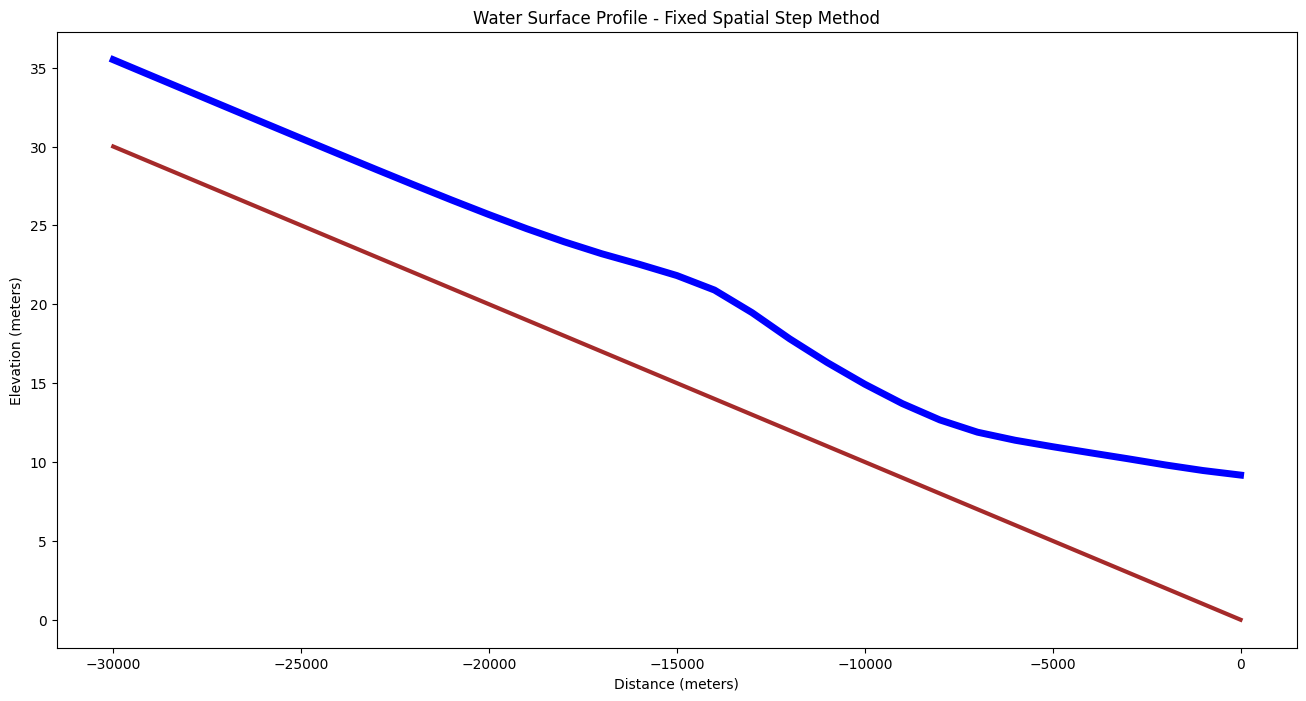

In [14]:
# Now plot the water surface profile
import matplotlib.pyplot
myfigure = matplotlib.pyplot.figure(figsize = (16,8)) # generate a object from the figure class, set aspect ratio
# Built the plot
matplotlib.pyplot.plot(distance, bottom,  color ='brown', linewidth=3)
matplotlib.pyplot.plot(distance, watersurface,  color ='blue', linewidth=5)
matplotlib.pyplot.ylabel("Elevation (meters)")
matplotlib.pyplot.xlabel("Distance (meters)")
mytitle = "Water Surface Profile - Fixed Spatial Step Method"
matplotlib.pyplot.title(mytitle)
matplotlib.pyplot.show()

## References

Koutitas, C. G. 1983. Elements of Computational Hydraulics. ISBN 0-412-00361-9. Pentech Press Ltd. London. (Chapter 4) [http://54.243.252.9/ce-5362-webroot/3-Readings/PracticalComputationalHydraulics-Kousitas/ElementsOfComputationalHydraulics.pdf](http://54.243.252.9/ce-5362-webroot/3-Readings/PracticalComputationalHydraulics-Kousitas/ElementsOfComputationalHydraulics.pdf)

Roberson, J. A., Cassidy, J.J., and Chaudry, M. H., (1988) Hydraulic Engineering, Houghton Mifflin Co (Chapter 10) [http://54.243.252.9/ce-5362-webroot/3-Readings/HydraulicEngineering/](http://54.243.252.9/ce-5362-webroot/3-Readings/HydraulicEngineering/)

Sturm T.W (2001) Open Channel Hydraulics, 1ed., McGraw-Hill, New York. Note: This PDF is from an international edition published in Singapore. [http://54.243.252.9/ce-5362-webroot/3-Readings/OpenChannelHYdraulics/](http://54.243.252.9/ce-5362-webroot/3-Readings/OpenChannelHYdraulics/)

Cunge, J.A., Holly, F.M., Verwey, A. (1980). Practical Aspects of Computational
River Hydraulics. Pittman Publishing Inc. , Boston, MA. pp. 7-50